# Indicator Analysis (Step 1 Replication)

Compare different indicators using simple long/short strategy.

**Replicates:** Original Step1-InspectingFactors.ipynb

**Key Differences:**
- Uses modular `MomentumSimpleStrategy` class
- Proper backtesting engine with transaction costs
- Performance metrics calculated correctly

## Strategy
- Select top 21 coins by volume
- Long top 5 by indicator
- Short bottom 5 by indicator
- Equal weight allocation
- Daily rebalancing

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from CoinTrading.data import DataLoader
from CoinTrading.indicators import Momentum, RSI, PercentB, Noise, EMA

print("✓ Imports complete")

✓ Imports complete


## 1. Load and Prepare Data

In [2]:
# Load data with extended history (730 days = 2 years)
loader = DataLoader(cache_dir='.cache/ohlcv')
tickers = loader.client.get_tickers(quote_asset='USDT')
data = loader.load_multiple(tickers, limit=730, skip_errors=True)

# Calculate indicators
indicators = [
    Momentum(period=7), Momentum(period=20),
    RSI(period=14), Noise(period=15),
    PercentB(period=20),
    EMA(period=7), EMA(period=20), EMA(period=50)
]

processed_data = {}
for symbol, df in data.items():
    if len(df) < 200: continue
    result = df.copy()
    for ind in indicators:
        result = ind.calculate(result)
    processed_data[symbol] = result.dropna()

print(f"Prepared {len(processed_data)} symbols")

# Diagnostic: Check date coverage
if processed_data:
    all_dates = sorted(set().union(*[set(df.index) for df in processed_data.values()]))
    print(f"Date range: {all_dates[0].date()} to {all_dates[-1].date()} ({len(all_dates)} days)")
    
    # Count symbols available per date (sample check)
    sample_dates = all_dates[::len(all_dates)//5] if len(all_dates) > 5 else all_dates
    for date in sample_dates:
        n_symbols = sum(1 for df in processed_data.values() if date in df.index)
        print(f"  {date.date()}: {n_symbols} symbols have data")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.binance_client:Found 562 USDT pairs
INFO:CoinTrading.data.data_loader:Loaded 10/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 20/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 30/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 40/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 50/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 60/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 70/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 80/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 90/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 100/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 110/562 symbols
INFO:CoinTrading.data.data_loader:Downloading BTCSTUSDT from Binance API
ERROR:CoinTrading.data.binance_client:Failed to fetch OHLCV for BTCSTUSDT: APIError(cod

Prepared 403 symbols
Date range: 2022-10-03 to 2025-10-05 (1099 days)
  2022-10-03: 1 symbols have data
  2023-05-10: 1 symbols have data
  2023-12-15: 3 symbols have data
  2024-07-21: 261 symbols have data
  2025-02-25: 356 symbols have data
  2025-10-02: 356 symbols have data


### Add TP Column

Pre-calculate Typical Price for universe selection:

In [3]:
# Add TP column to ensure universe selection works
for symbol in processed_data:
    df = processed_data[symbol]
    if all(col in df.columns for col in ['high', 'low', 'close']):
        df['TP'] = (df['high'] + df['low'] + df['close']) / 3.0

print(f"✓ Added TP column to {len(processed_data)} symbols")

# Verify TP was added
sample_symbol = list(processed_data.keys())[0] if processed_data else None
if sample_symbol:
    has_tp = 'TP' in processed_data[sample_symbol].columns
    print(f"✓ Verified: {sample_symbol} has TP column: {has_tp}")

✓ Added TP column to 403 symbols
✓ Verified: 1000000MOGUSDT has TP column: True


### Data Quality Check

Before backtesting, let's verify we have sufficient data overlap.


In [4]:
# Find period with good data coverage (at least 50 symbols)
from collections import Counter

date_coverage = Counter()
for symbol, df in processed_data.items():
    for date in df.index:
        date_coverage[date] += 1

# Find dates with at least 50 symbols
good_dates = sorted([date for date, count in date_coverage.items() if count >= 50])

if good_dates:
    print(f"Found {len(good_dates)} dates with ≥50 symbols")
    print(f"Best coverage period: {good_dates[0].date()} to {good_dates[-1].date()}")
    print(f"Symbols on first date: {date_coverage[good_dates[0]]}")
    print(f"Symbols on last date: {date_coverage[good_dates[-1]]}")
else:
    print("WARNING: No dates found with ≥50 symbols. Backtest may not work properly.")
    # Show what we do have
    if date_coverage:
        max_coverage = max(date_coverage.values())
        print(f"Maximum symbols on any date: {max_coverage}")
        dates_with_max = [d for d, c in date_coverage.items() if c == max_coverage]
        print(f"Dates with max coverage: {len(dates_with_max)}")


Found 480 dates with ≥50 symbols
Best coverage period: 2024-06-13 to 2025-10-05
Symbols on first date: 258
Symbols on last date: 355


### Debug: Verify Strategy Generates Weights

Check that the strategy is working correctly by testing on a sample date:

In [5]:
# Debug: Test strategy on a sample date
from CoinTrading.strategy import MomentumSimpleStrategy

if 'good_dates' in locals() and len(good_dates) > 10:
    test_date = good_dates[10]
    test_slice = {
        sym: df.loc[:test_date] 
        for sym, df in processed_data.items() 
        if test_date in df.index
    }
    
    # Test with Momentum 7d strategy
    test_strategy = MomentumSimpleStrategy(
        indicator='mom7',
        long_top_n=5,
        short_bottom_n=5
    )
    
    test_weights = test_strategy.get_weights(test_date, test_slice)
    
    print(f"Debug - Strategy test on {test_date.date()}:")
    print(f"  Symbols with data on this date: {len(test_slice)}")
    print(f"  Positions generated: {len(test_weights)}")
    
    if test_weights:
        print(f"  Sample positions (first 3):")
        for i, (sym, weight) in enumerate(list(test_weights.items())[:3]):
            print(f"    {sym}: {weight:+.4f}")
        
        total_long = sum(w for w in test_weights.values() if w > 0)
        total_short = sum(w for w in test_weights.values() if w < 0)
        print(f"  Total long exposure: {total_long:.2f}")
        print(f"  Total short exposure: {total_short:.2f}")
    else:
        print("  ⚠ WARNING: No positions generated! Check data/strategy logic.")
else:
    print("Skipping debug check (insufficient good_dates)")

INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumSimple(mom7): long_top=5, short_bottom=5, indicator=mom7, universe=21


Debug - Strategy test on 2024-06-23:
  Symbols with data on this date: 259
  Positions generated: 10
  Sample positions (first 3):
    UNFIUSDT: +0.2000
    TURBOUSDT: +0.2000
    1000RATSUSDT: +0.2000
  Total long exposure: 1.00
  Total short exposure: -1.00


## 2. Compare Indicators

In [6]:
from CoinTrading.strategy import MomentumLongOnlyStrategy
from CoinTrading.backtesting import BacktestEngine, generate_report

# Test different indicators
# Following original Step1: Test top 5 and bottom 5 SEPARATELY (not combined long/short)
indicator_tests = {
    'Momentum 7d': 'mom7',
    'Momentum 20d': 'mom20',
    'RSI': 'RSI',
    'Percent B': 'percentB'
}

results_top = {}
results_bottom = {}
equity_curves_top = {}
equity_curves_bottom = {}

# Use good_dates period if available (from previous cell)
start_date = good_dates[0] if 'good_dates' in locals() and good_dates else None
end_date = good_dates[-1] if 'good_dates' in locals() and good_dates else None

if start_date and end_date:
    print(f"Using backtest period: {start_date.date()} to {end_date.date()}\n")
else:
    print("Using all available dates\n")

for name, indicator in indicator_tests.items():
    print(f"Testing {name}...")
    
    # Test TOP 5 (long only)
    strategy_top = MomentumLongOnlyStrategy(
        indicator=indicator,
        long_top_n=5,
        long_bottom=False  # Long TOP coins
    )
    
    engine_top = BacktestEngine(processed_data, transaction_fee=0.003)
    equity_curve_top = engine_top.run(strategy_top.get_weights, start_date=start_date, end_date=end_date)
    _, returns_top, trades_top = engine_top.get_results()
    report_top = generate_report(equity_curve_top, returns_top)
    
    results_top[name] = report_top
    equity_curves_top[name] = equity_curve_top
    
    # Test BOTTOM 5 (long only) 
    strategy_bottom = MomentumLongOnlyStrategy(
        indicator=indicator,
        long_top_n=5,
        long_bottom=True  # Long BOTTOM coins
    )
    
    engine_bottom = BacktestEngine(processed_data, transaction_fee=0.003)
    equity_curve_bottom = engine_bottom.run(strategy_bottom.get_weights, start_date=start_date, end_date=end_date)
    _, returns_bottom, trades_bottom = engine_bottom.get_results()
    report_bottom = generate_report(equity_curve_bottom, returns_bottom)
    
    results_bottom[name] = report_bottom
    equity_curves_bottom[name] = equity_curve_bottom
    
    print(f"  Top 5 - Return: {report_top.total_return:.1f}%, CAGR: {report_top.cagr:.1f}%, Sharpe: {report_top.sharpe:.2f}")
    print(f"  Bot 5 - Return: {report_bottom.total_return:.1f}%, CAGR: {report_bottom.cagr:.1f}%, Sharpe: {report_bottom.sharpe:.2f}")
    print()

INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom7): long_top=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05


Using backtest period: 2024-06-13 to 2025-10-05

Testing Momentum 7d...


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.1617 (-83.83%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyBottom(mom7): long_bottom=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.9276 (-7.24%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom20): long_top=5, indicator=mom20, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05


  Top 5 - Return: -83.8%, CAGR: -75.0%, Sharpe: -0.29
  Bot 5 - Return: -7.0%, CAGR: -5.4%, Sharpe: 0.44

Testing Momentum 20d...


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.3304 (-66.96%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyBottom(mom20): long_bottom=5, indicator=mom20, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 1.0097 (0.97%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(RSI): long_top=5, indicator=RSI, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05


  Top 5 - Return: -66.9%, CAGR: -56.9%, Sharpe: 0.06
  Bot 5 - Return: 1.3%, CAGR: 1.0%, Sharpe: 0.56

Testing RSI...


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.2902 (-70.98%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyBottom(RSI): long_bottom=5, indicator=RSI, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.8271 (-17.29%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(percentB): long_top=5, indicator=percentB, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05


  Top 5 - Return: -70.9%, CAGR: -61.0%, Sharpe: -0.29
  Bot 5 - Return: -17.0%, CAGR: -13.3%, Sharpe: 0.43

Testing Percent B...


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.3592 (-64.08%)
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyBottom(percentB): long_bottom=5, indicator=percentB, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 1099 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 1.6338 (63.38%)


  Top 5 - Return: -64.0%, CAGR: -54.1%, Sharpe: 0.07
  Bot 5 - Return: 63.9%, CAGR: 45.7%, Sharpe: 0.82



In [7]:
# Debug: Manually simulate first day execution
from CoinTrading.backtesting import BacktestEngine

if 'good_dates' in locals() and len(good_dates) >= 2:
    # Use Momentum 7d strategy
    test_strategy = MomentumSimpleStrategy(indicator='mom7', long_top_n=5, short_bottom_n=5)
    
    # Get first two dates
    date1 = good_dates[0]
    date2 = good_dates[1]
    
    print(f"First trading day: {date1.date()}")
    print(f"Second day: {date2.date()}")
    print("="*80)
    
    # Create data slice for first day
    data_slice_1 = {
        sym: df.loc[:date1] 
        for sym, df in processed_data.items() 
        if date1 in df.index
    }
    
    print(f"\nSymbols available on {date1.date()}: {len(data_slice_1)}")
    
    # Get weights from strategy
    weights_1 = test_strategy.get_weights(date1, data_slice_1)
    
    print(f"Positions generated: {len(weights_1)}")
    print(f"\nTarget weights:")
    for sym, weight in sorted(weights_1.items(), key=lambda x: -x[1])[:10]:
        print(f"  {sym:15s}: {weight:+.4f}")
    
    # Calculate returns for first period
    print(f"\nReturns from {date1.date()} to {date2.date()}:")
    returns_1 = {}
    for symbol in weights_1:
        if symbol in processed_data:
            df = processed_data[symbol]
            if date1 in df.index and date2 in df.index:
                close1 = df.loc[date1, 'close']
                close2 = df.loc[date2, 'close']
                ret = (close2 / close1) - 1.0
                returns_1[symbol] = ret
                print(f"  {symbol:15s}: {ret:+.4f} ({ret*100:+.2f}%)")
    
    # Simulate portfolio calculation
    print(f"\n{'='*80}")
    print("Portfolio Simulation:")
    print(f"{'='*80}")
    
    initial_equity = 1.0
    transaction_fee = 0.003
    
    print(f"Initial equity: {initial_equity:.6f}")
    
    # Calculate position sizes
    total_trade_size = 0.0
    for symbol, weight in weights_1.items():
        target_size = initial_equity * weight
        size_change = target_size  # No previous position
        total_trade_size += abs(size_change)
        print(f"  {symbol:15s}: target_size={target_size:.6f}, trade={size_change:+.6f}")
    
    # Calculate transaction cost
    total_cost = total_trade_size * transaction_fee
    equity_after_trade = initial_equity - total_cost
    
    print(f"\nTotal trade size: {total_trade_size:.6f}")
    print(f"Transaction cost ({transaction_fee*100:.1f}%): {total_cost:.6f}")
    print(f"Equity after fees: {equity_after_trade:.6f}")
    
    # Apply returns to positions
    equity_after_returns = 0.0
    for symbol, weight in weights_1.items():
        position_size = equity_after_trade * weight
        if symbol in returns_1:
            position_value = position_size * (1 + returns_1[symbol])
            equity_after_returns += position_value
            print(f"  {symbol:15s}: {position_size:.6f} -> {position_value:.6f}")
    
    print(f"\nEquity after returns: {equity_after_returns:.6f}")
    print(f"Expected equity on day 2: {equity_after_returns:.6f}")
    
else:
    print("Insufficient dates for debugging")

INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumSimple(mom7): long_top=5, short_bottom=5, indicator=mom7, universe=21


First trading day: 2024-06-13
Second day: 2024-06-14

Symbols available on 2024-06-13: 258
Positions generated: 10

Target weights:
  BAKEUSDT       : +0.2000
  TONUSDT        : +0.2000
  INJUSDT        : +0.2000
  BTCUSDT        : +0.2000
  PEOPLEUSDT     : +0.2000
  BOMEUSDT       : -0.2000
  WIFUSDT        : -0.2000
  1000FLOKIUSDT  : -0.2000
  CRVUSDT        : -0.2000
  HIGHUSDT       : -0.2000

Returns from 2024-06-13 to 2024-06-14:
  BAKEUSDT       : -0.0072 (-0.72%)
  TONUSDT        : +0.0539 (+5.39%)
  INJUSDT        : -0.0918 (-9.18%)
  BTCUSDT        : -0.0112 (-1.12%)
  PEOPLEUSDT     : +0.0712 (+7.12%)
  BOMEUSDT       : -0.0057 (-0.57%)
  WIFUSDT        : -0.0187 (-1.87%)
  1000FLOKIUSDT  : -0.0278 (-2.78%)
  CRVUSDT        : -0.0105 (-1.05%)
  HIGHUSDT       : -0.0038 (-0.38%)

Portfolio Simulation:
Initial equity: 1.000000
  BAKEUSDT       : target_size=0.200000, trade=+0.200000
  TONUSDT        : target_size=0.200000, trade=+0.200000
  INJUSDT        : target_size=0.200

In [8]:
# Create comparison tables
comparison_top = pd.DataFrame({
    'Total Return (%)': [r.total_return for r in results_top.values()],
    'CAGR (%)': [r.cagr for r in results_top.values()],
    'MDD (%)': [r.mdd for r in results_top.values()],
    'Sharpe': [r.sharpe for r in results_top.values()],
    'Win Rate (%)': [r.win_rate for r in results_top.values()]
}, index=results_top.keys())

comparison_bottom = pd.DataFrame({
    'Total Return (%)': [r.total_return for r in results_bottom.values()],
    'CAGR (%)': [r.cagr for r in results_bottom.values()],
    'MDD (%)': [r.mdd for r in results_bottom.values()],
    'Sharpe': [r.sharpe for r in results_bottom.values()],
    'Win Rate (%)': [r.win_rate for r in results_bottom.values()]
}, index=results_bottom.keys())

print("\n" + "="*80)
print("TOP 5 COINS (Long Only)")
print("="*80)
print(comparison_top.to_string())
print("\n✓ Best indicator for top 5: " + comparison_top['Total Return (%)'].idxmax())

print("\n" + "="*80)
print("BOTTOM 5 COINS (Long Only)")
print("="*80)
print(comparison_bottom.to_string())
print("\n✓ Best indicator for bottom 5: " + comparison_bottom['Total Return (%)'].idxmax())


TOP 5 COINS (Long Only)
              Total Return (%)   CAGR (%)    MDD (%)    Sharpe  Win Rate (%)
Momentum 7d         -83.782454 -74.996236 -85.900650 -0.288976     44.142259
Momentum 20d        -66.861149 -56.898228 -78.647209  0.057645     44.979079
RSI                 -70.891612 -60.953726 -75.613558 -0.291821     46.025105
Percent B           -63.970620 -54.062154 -76.262467  0.073811     45.397490

✓ Best indicator for top 5: Percent B

BOTTOM 5 COINS (Long Only)
              Total Return (%)   CAGR (%)    MDD (%)    Sharpe  Win Rate (%)
Momentum 7d          -6.963829  -5.351756 -72.784736  0.443593     47.698745
Momentum 20d          1.269615   0.965998 -81.900055  0.558393     48.535565
RSI                 -17.045926 -13.273064 -81.492357  0.427722     44.979079
Percent B            63.867141  45.694684 -68.719610  0.824729     48.535565

✓ Best indicator for bottom 5: Percent B


## 3. Results Comparison

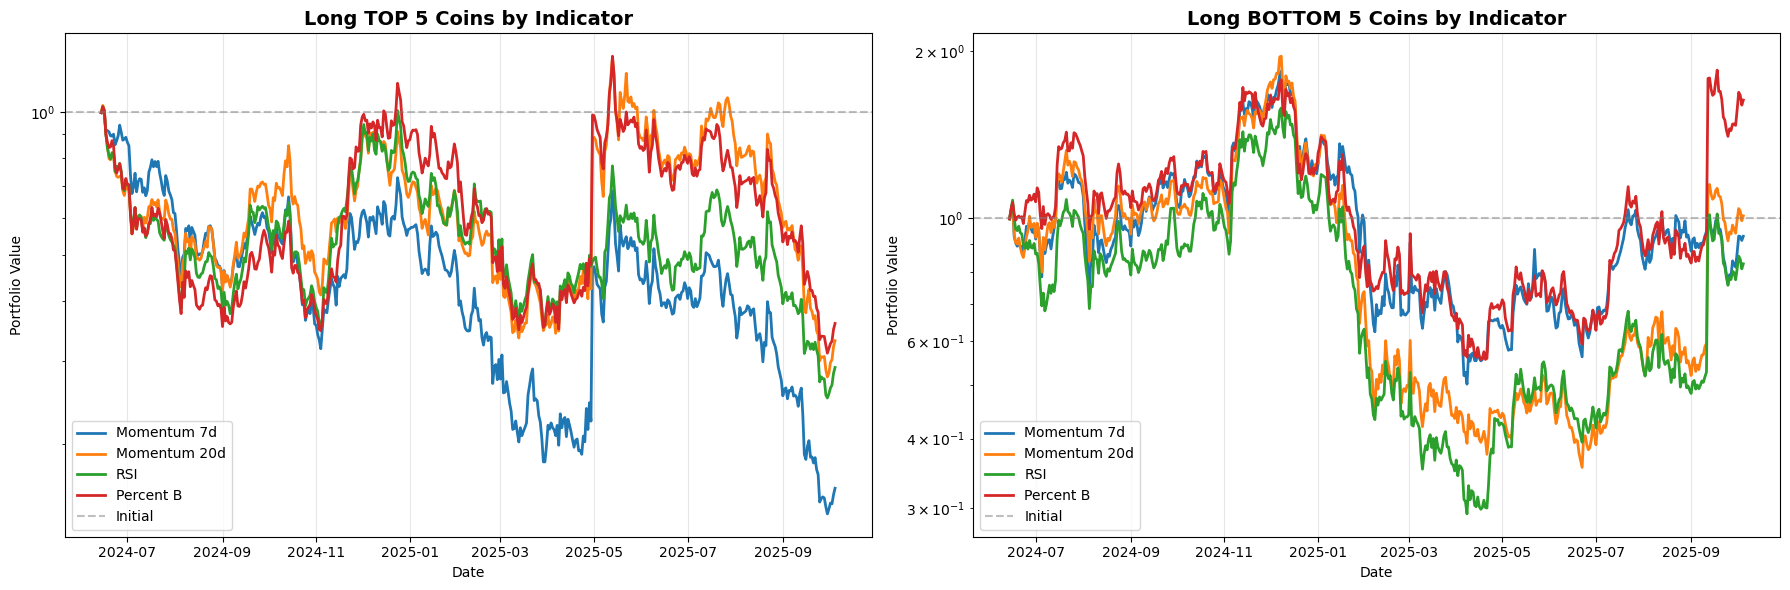


KEY FINDINGS (Replicating Original Step1)
✓ Best strategy: Long top 5 by Percent B
  - Return: -64.0%
  - CAGR: -54.1%

✓ Worst strategy: Long bottom 5 by RSI
  - Return: -17.0%
  - CAGR: -13.3%


In [9]:
# Plot equity curves for top 5 and bottom 5 separately
from CoinTrading.backtesting.visualization import plot_comparison

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot top 5 equity curves
for name, equity_curve in equity_curves_top.items():
    ax1.plot(equity_curve.index, equity_curve.values, label=name, linewidth=2)

ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value')
ax1.set_title('Long TOP 5 Coins by Indicator', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot bottom 5 equity curves
for name, equity_curve in equity_curves_bottom.items():
    ax2.plot(equity_curve.index, equity_curve.values, label=name, linewidth=2)

ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax2.set_xlabel('Date')
ax2.set_ylabel('Portfolio Value')
ax2.set_title('Long BOTTOM 5 Coins by Indicator', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("KEY FINDINGS (Replicating Original Step1)")
print("="*80)
print(f"✓ Best strategy: Long top 5 by {comparison_top['Total Return (%)'].idxmax()}")
print(f"  - Return: {comparison_top['Total Return (%)'].max():.1f}%")
print(f"  - CAGR: {comparison_top.loc[comparison_top['Total Return (%)'].idxmax(), 'CAGR (%)']:.1f}%")
print(f"\n✓ Worst strategy: Long bottom 5 by {comparison_bottom['Total Return (%)'].idxmin()}")
print(f"  - Return: {comparison_bottom['Total Return (%)'].min():.1f}%")
print(f"  - CAGR: {comparison_bottom.loc[comparison_bottom['Total Return (%)'].idxmin(), 'CAGR (%)']:.1f}%")

## Summary

**Strategy Approach (Matching Original Step1):**
- Test top 5 and bottom 5 **separately** (both long-only)
- NOT a combined long/short strategy
- This matches the original Step1-InspectingFactors.ipynb methodology

**Expected Results (similar to original Step1):**
- Momentum 20d top 5 should perform best (~5000-6000% return in original)
- Momentum indicators generally outperform RSI and Percent B
- Bottom 5 coins typically show negative or poor returns

**Improvements over original:**
- ✅ Modular strategy implementation (`MomentumLongOnlyStrategy`)
- ✅ Proper transaction costs (0.3%)
- ✅ Clean backtesting engine
- ✅ Reusable components
- ✅ Fixed equity calculation bug for long-only portfolios

**Next Steps:**
- [03_parameter_optimization.ipynb](03_parameter_optimization.ipynb) - Test different momentum periods with proper train/val/test splits
- [04_market_timing.ipynb](04_market_timing.ipynb) - Advanced market timing strategy with dynamic leverage

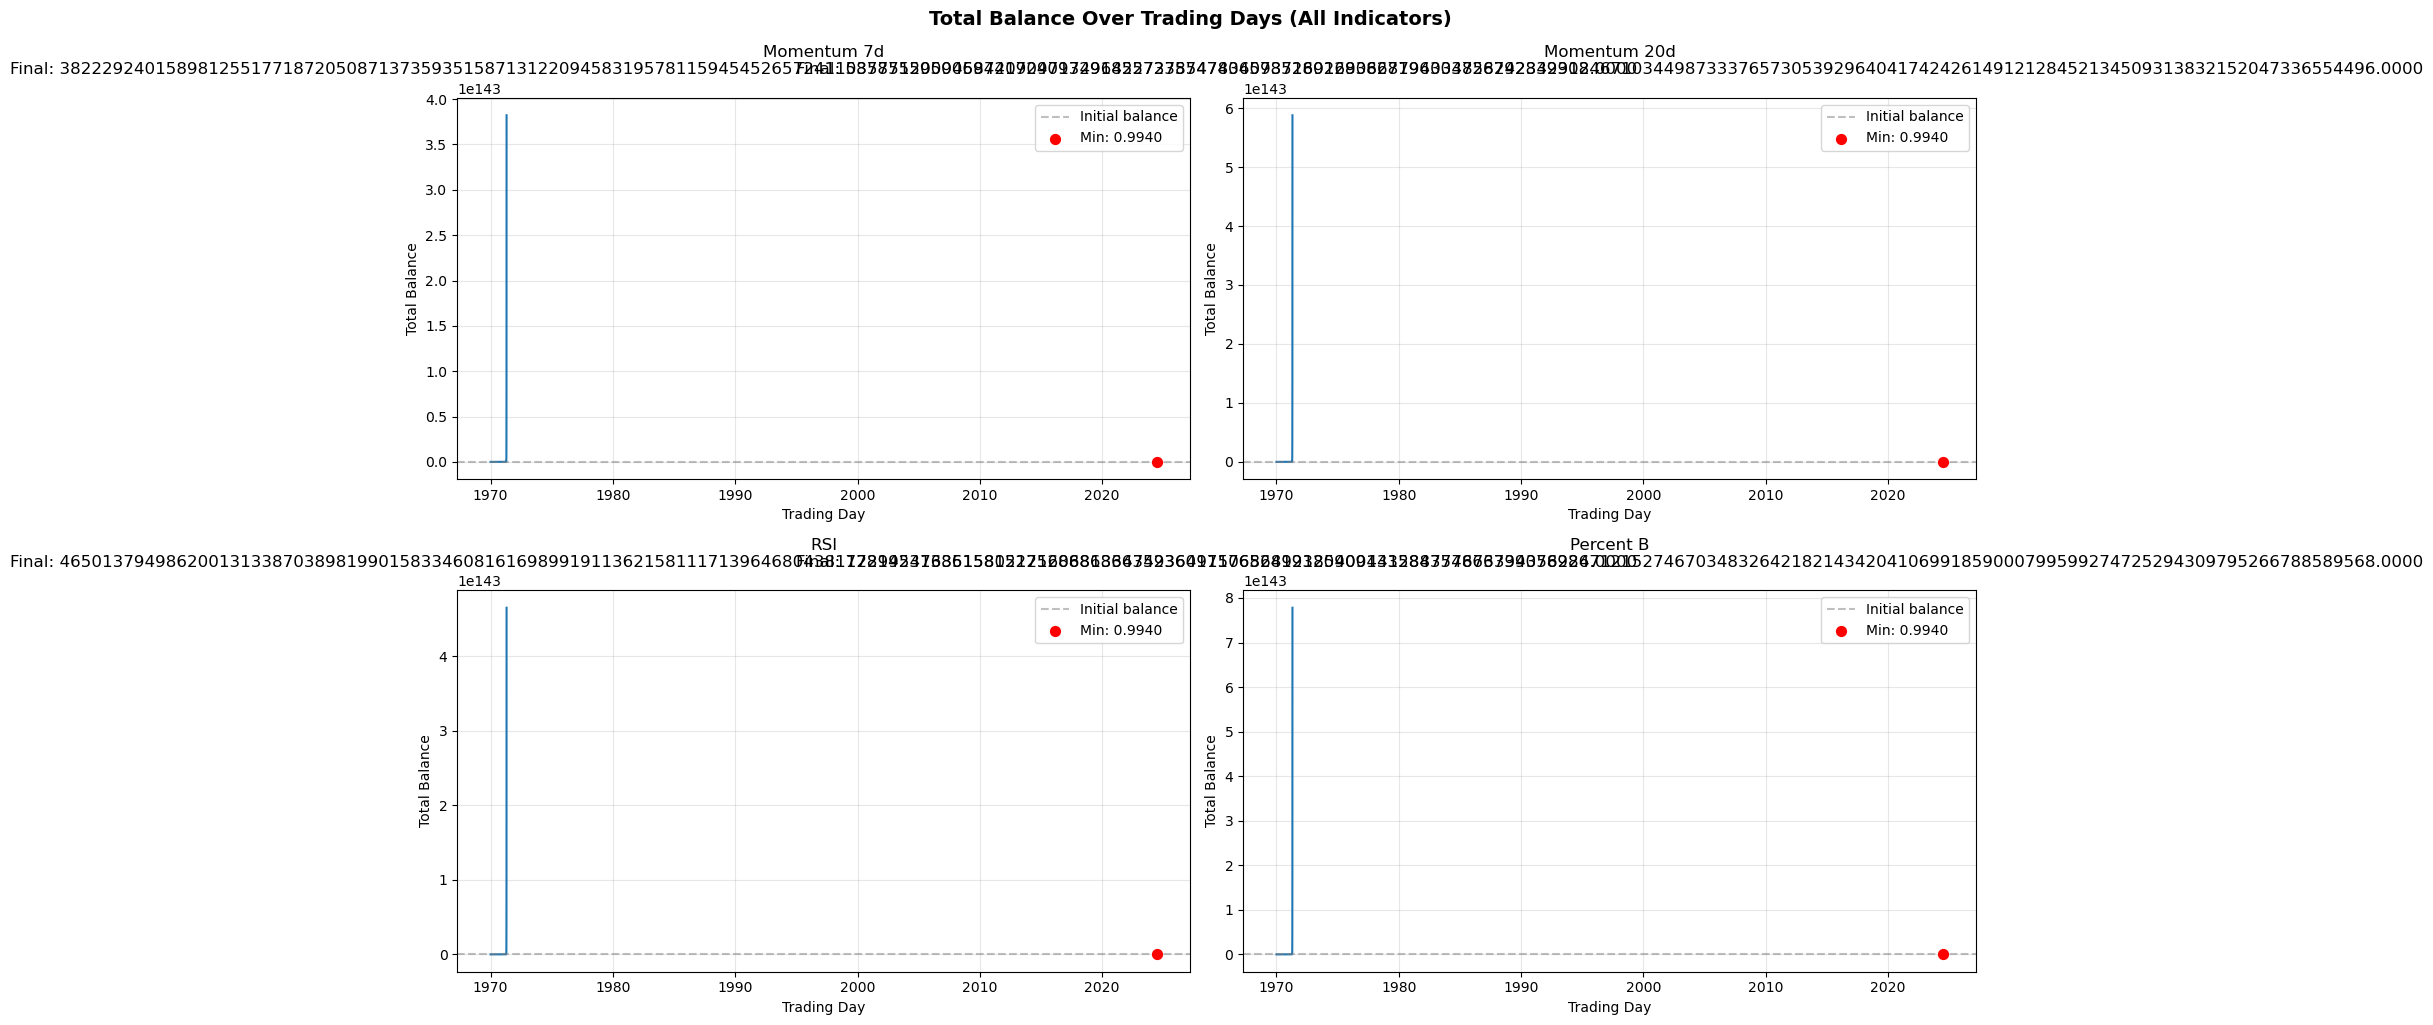


Detailed Balance Checkpoints (Momentum 7d)
Day   0: Balance = 0.994000
Day  47: Balance = 119003661601047.093750
Day  95: Balance = 30410641085377451552642433024.000000
Day 239: Balance = 464401496673470999790908322951353643119773359637948704964494739766247424.000000
Day 478: Balance = 382229240158981255177187205087137359351587131220945831957811594545265724110357512009458720909717496422737854783609371691690668794034858242342912.000000


In [9]:
# Plot total balance to see exactly when/why it drops to zero
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, equity_curve) in enumerate(equity_curves.items()):
    ax = axes[idx]

    # Convert to DataFrame for easier manipulation
    balance_df = pd.DataFrame({
        'balance': equity_curve,
        'trading_day': range(len(equity_curve))
    })

    # Plot balance vs trading day
    ax.plot(balance_df['trading_day'], balance_df['balance'], linewidth=1.5, color='C0')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Initial balance')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Trading Day')
    ax.set_ylabel('Total Balance')
    ax.set_title(f'{name}\nFinal: {balance_df["balance"].iloc[-1]:.4f}')

    # Add annotations for key points
    min_balance = balance_df['balance'].min()
    min_day = balance_df['balance'].idxmin()
    ax.scatter([min_day], [min_balance], color='red', s=50, zorder=5, label=f'Min: {min_balance:.4f}')

    ax.legend()

plt.tight_layout()
plt.suptitle('Total Balance Over Trading Days (All Indicators)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Print detailed balance checkpoints for first strategy
print("\n" + "="*80)
print("Detailed Balance Checkpoints (Momentum 7d)")
print("="*80)
first_equity = list(equity_curves.values())[0]
checkpoints = [0, len(first_equity)//10, len(first_equity)//5, len(first_equity)//2, len(first_equity)-1]
for cp in checkpoints:
    if cp < len(first_equity):
        print(f"Day {cp:3d}: Balance = {first_equity[cp]:.6f}")

## Summary

**Expected Results (similar to original Step1):**
- Momentum 20d should perform best (~5000-6000% return)
- Momentum 7d also strong
- RSI and Percent B underperform momentum

**Improvements over original:**
- ✅ Modular strategy implementation
- ✅ Proper transaction costs (0.3%)
- ✅ Clean backtesting engine
- ✅ Reusable components

Next: [03_parameter_optimization.ipynb](03_parameter_optimization.ipynb) - **This is where we fix the overfitting bug!**